In [1]:
import numpy as np
import pandas as pd
import random
import statistics as stat
from datetime import date

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import math


## 1. Анализ данных

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [5]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### 1.1. Целевая переменная

In [7]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### 1.2. Числовые признаки

In [8]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 1.3. Категориальные признаки

In [9]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [10]:
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = train_df.columns.drop(CAT_FEATURE_NAMES + [TARGET_NAME]).tolist()

### 1.4. Корреляция числовых признаков с целевой переменной

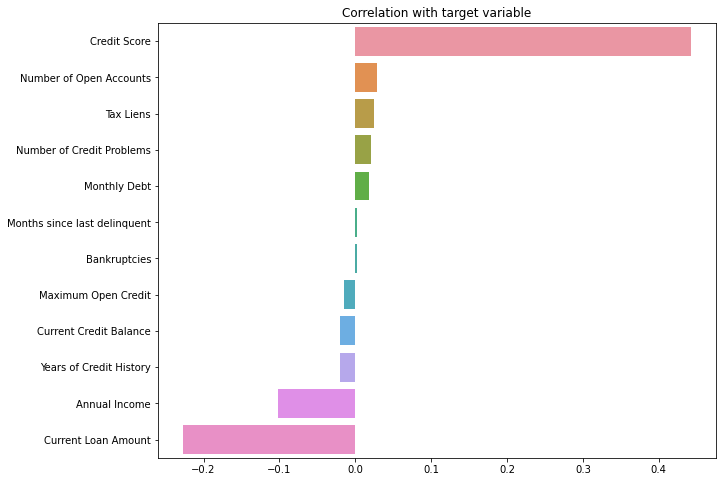

In [11]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

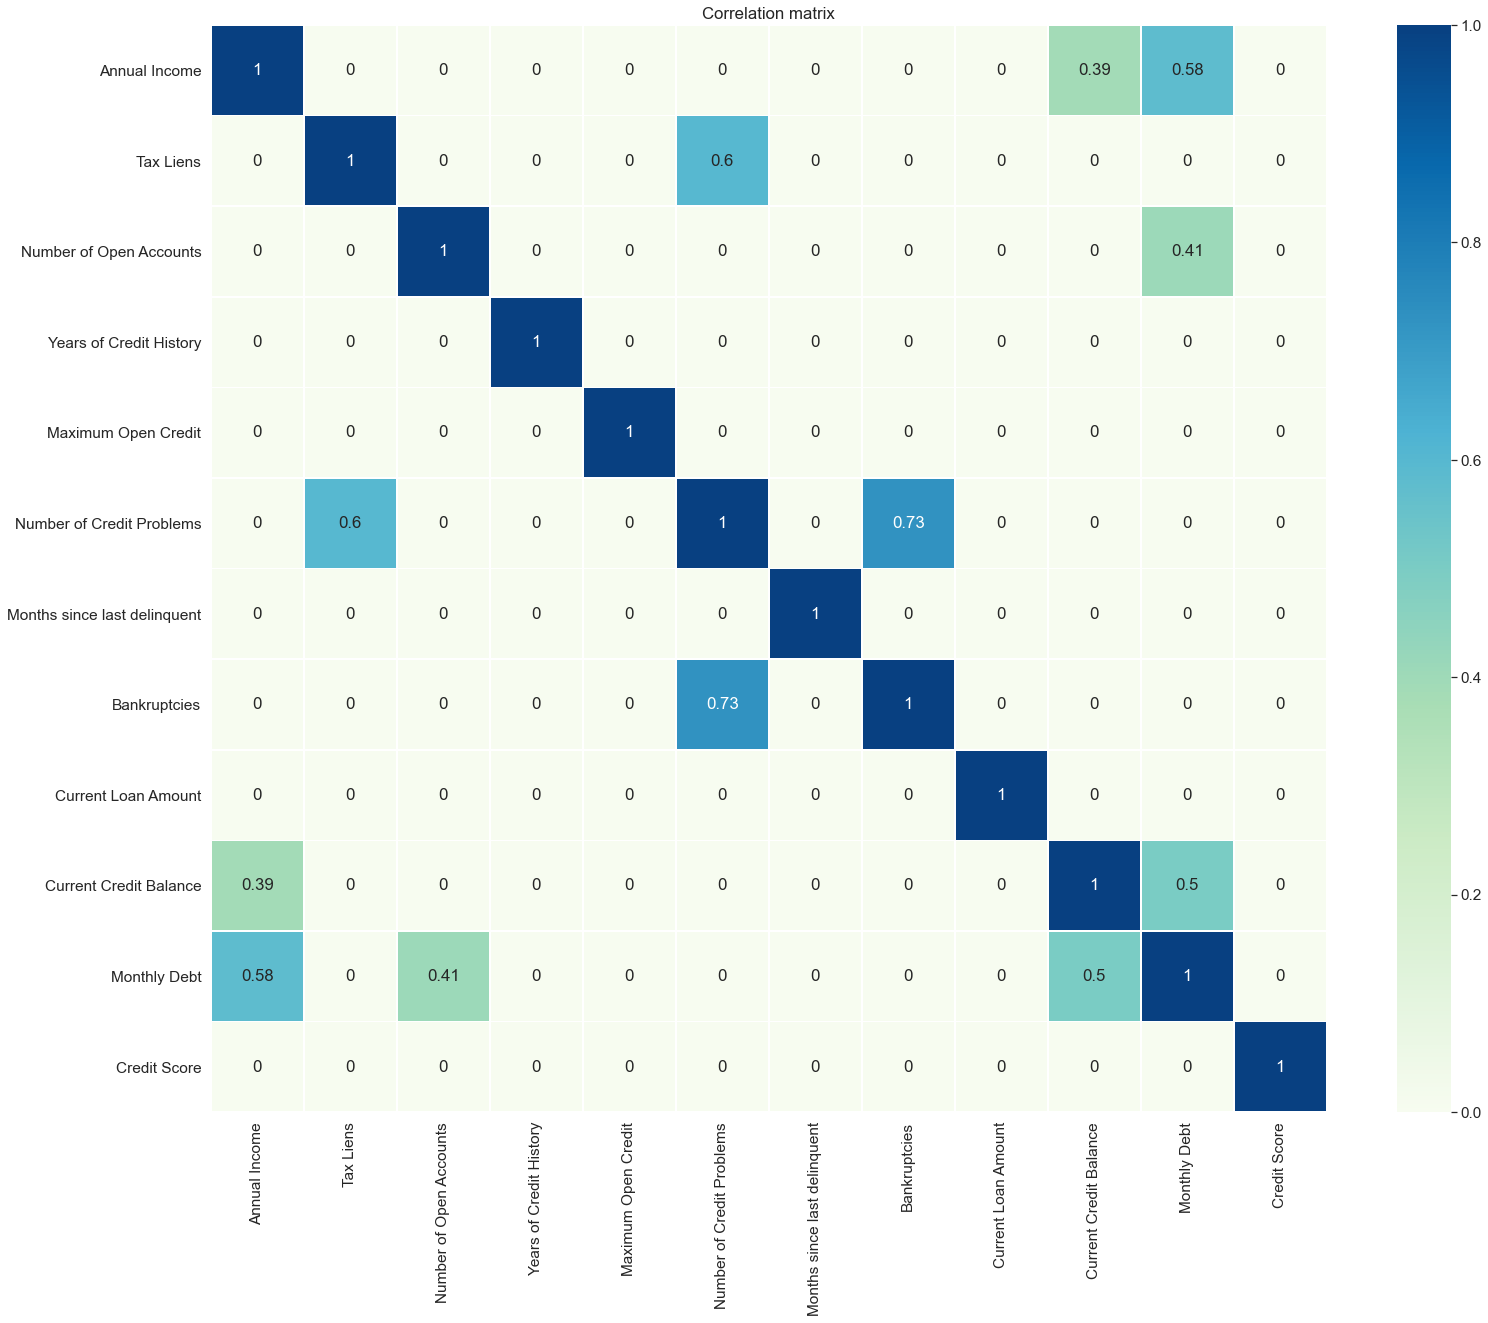

In [12]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = train_df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Сравним признаки на train и test:

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


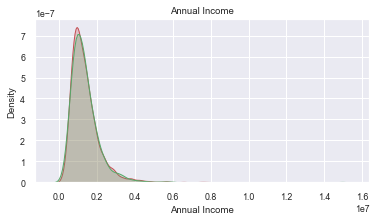

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


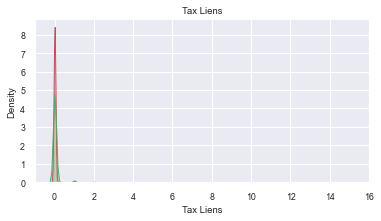

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


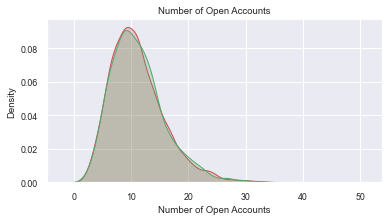

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


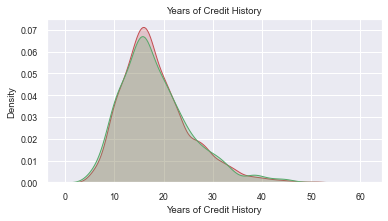

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


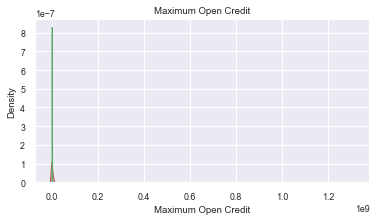

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


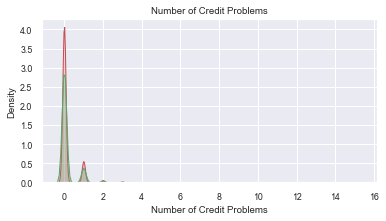

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


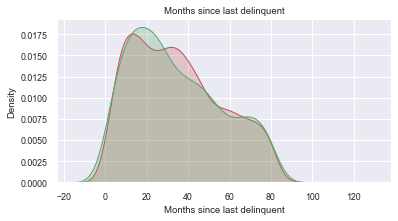

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


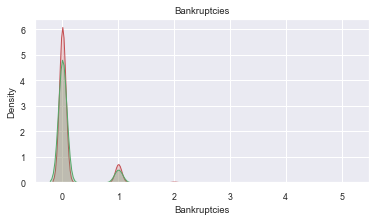

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


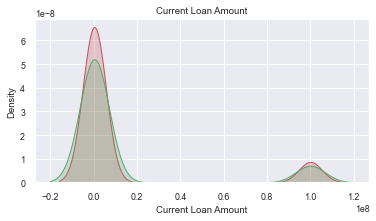

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


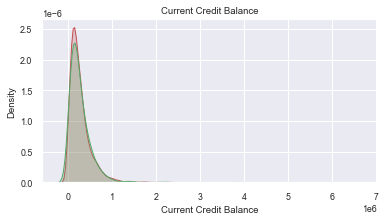

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


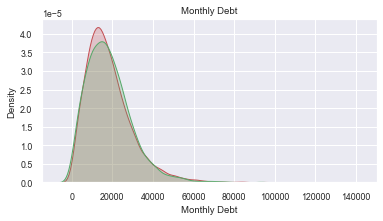

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


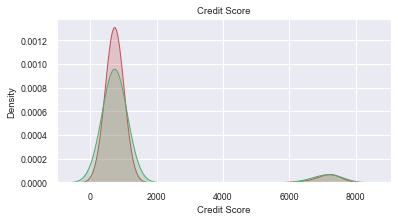

In [13]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.title(col)
    plt.show()

Months since last delinquent, Bankruptcies имеют разные средние значения. Не будем на них обучаться.

### 1.5. Похожесть категориальных признаков на train и test

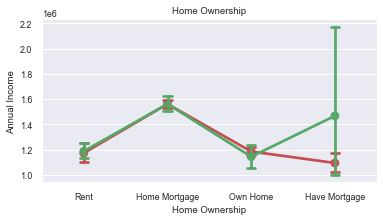

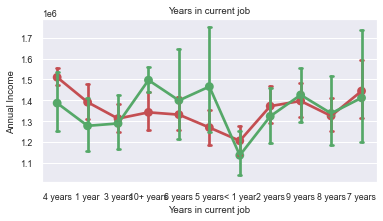

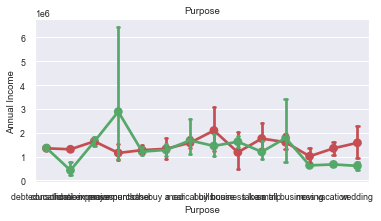

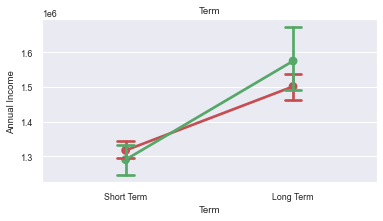

In [14]:
# используем числовой признак Annual Income как опору для сравнения распределений категориальных признаков
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

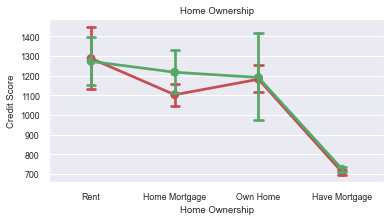

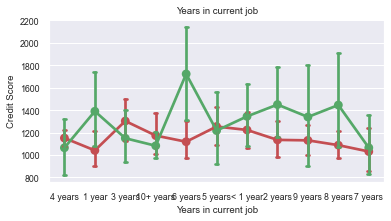

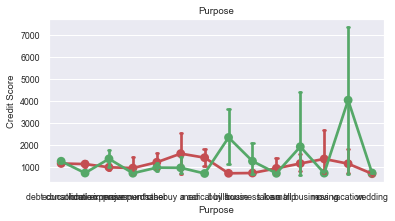

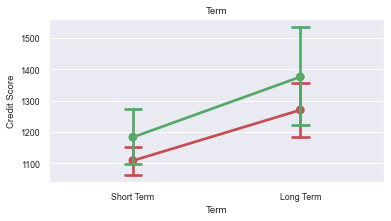

In [15]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

"Years in current job" и "Purpose" не во всех точках имеют похожие доверительные интервалы.

## 2. Обработка пропусков и выбросов

### 2.1. Категориальные признаки

Home Ownership.Объединяем значения Home Mortgage и Have Mortgage

In [16]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'
test_df.loc[test_df['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

Сделаем группировку по признаку "Years in current job" нужно посчитать среднее значение целевого признака. Может быть есть зависимость целевой переменной от значений этого признака

In [17]:
groupby = train_df.groupby("Years in current job")
groupby["Credit Default"].mean()

Years in current job
1 year       0.281746
10+ years    0.276158
2 years      0.273759
3 years      0.274194
4 years      0.279318
5 years      0.281008
6 years      0.291080
7 years      0.280303
8 years      0.271386
9 years      0.250965
< 1 year     0.282416
Name: Credit Default, dtype: float64

Корреляции с целевым признаком не обнаружено. Можно вообще отказаться от этого признака

In [18]:
#train_df["Years in current job"] = train_df["Years in current job"].fillna(train_df["Years in current job"].mode()[0])
BASE_FEATURE_NAMES.remove('Years in current job')
train_df.drop(['Years in current job'], axis='columns', inplace=True)
test_df.drop(['Years in current job'], axis='columns', inplace=True)
CAT_FEATURE_NAMES.remove('Years in current job')

Purpose. Очень много значений категорий. Попробуем сократить

In [19]:
groupby = train_df.groupby("Purpose")
purp_value = groupby["Credit Default"].mean().sort_values()
list_value = purp_value.index.tolist()
purp_value

Purpose
educational expenses    0.100000
moving                  0.181818
major purchase          0.225000
buy a car               0.250000
vacation                0.250000
home improvements       0.262136
buy house               0.264706
wedding                 0.266667
take a trip             0.270270
debt consolidation      0.278264
other                   0.296241
medical bills           0.309859
business loan           0.426357
small business          0.538462
renewable energy        1.000000
Name: Credit Default, dtype: float64

In [20]:
# plt.figure(figsize=(18, 15))

# sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
# plt.title('Purpose grouped by target variable')
# plt.legend(title='Target', loc='upper right')

# plt.show()

In [21]:
df_chi2 = pd.DataFrame(columns = ['el1', 'el2', 'p'])
train_df['Id'] = train_df.index
i = 0
for el1 in list_value:
    for el2 in list_value:
        if el1 == el2:
            continue
        Purpose_and_target = train_df.loc[train_df['Purpose'].isin([el1, el2]), ['Id', 'Purpose', TARGET_NAME]]
        table = Purpose_and_target.pivot_table(values='Id', index='Purpose', columns=TARGET_NAME, aggfunc='count')
        chi2, p, _, _ = chi2_contingency(table)
        if p < 0.05 or math.isnan(p):
            continue
        i = i + 1
        df_chi2.loc[i] = [el1, el2, p]

In [22]:
df_chi2.sort_values('p', ascending=False).head(30)

,el1,el2,p
40,buy a car,vacation,1.000000
51,vacation,buy a car,1.000000
117,debt consolidation,buy house,0.987245
80,buy house,debt consolidation,0.987245
44,buy a car,take a trip,0.985364
101,take a trip,buy a car,0.985364
140,medical bills,wedding,0.982780
95,wedding,medical bills,0.982780
87,wedding,major purchase,0.974159
32,major purchase,wedding,0.974159


In [23]:
train_df.loc[train_df['Purpose'] == 'buy a car', "Purpose"] = 'vacation'
train_df.loc[train_df['Purpose'] == 'buy house', "Purpose"] = 'debt consolidation'
train_df.loc[train_df['Purpose'] == 'vacation', "Purpose"] = 'take a trip'

train_df.loc[train_df['Purpose'] == 'medical bills', "Purpose"] = 'wedding'
train_df.loc[train_df['Purpose'] == 'major purchase', "Purpose"] = 'wedding'
train_df.loc[train_df['Purpose'] == 'moving', "Purpose"] = 'wedding'

train_df.loc[train_df['Purpose'] == 'take a trip', "Purpose"] = 'wedding'
train_df.loc[train_df['Purpose'] == 'home improvements', "Purpose"] = 'wedding'
train_df.loc[train_df['Purpose'] == 'debt consolidation', "Purpose"] = 'wedding'

train_df.loc[train_df['Purpose'] == 'business loan', "Purpose"] = 'small business'
train_df.loc[train_df['Purpose'] == 'educational expenses', "Purpose"] = 'wedding'
train_df.loc[train_df['Purpose'] == 'other', "Purpose"] = 'wedding'

In [24]:
test_df.loc[test_df['Purpose'] == 'buy a car', "Purpose"] = 'vacation'
test_df.loc[test_df['Purpose'] == 'buy house', "Purpose"] = 'debt consolidation'
test_df.loc[test_df['Purpose'] == 'vacation', "Purpose"] = 'take a trip'

test_df.loc[test_df['Purpose'] == 'medical bills', "Purpose"] = 'wedding'
test_df.loc[test_df['Purpose'] == 'major purchase', "Purpose"] = 'wedding'
test_df.loc[test_df['Purpose'] == 'moving', "Purpose"] = 'wedding'

test_df.loc[test_df['Purpose'] == 'take a trip', "Purpose"] = 'wedding'
test_df.loc[test_df['Purpose'] == 'home improvements', "Purpose"] = 'wedding'
test_df.loc[test_df['Purpose'] == 'debt consolidation', "Purpose"] = 'wedding'

test_df.loc[test_df['Purpose'] == 'business loan', "Purpose"] = 'small business'
test_df.loc[test_df['Purpose'] == 'educational expenses', "Purpose"] = 'wedding'
test_df.loc[test_df['Purpose'] == 'other', "Purpose"] = 'wedding'


Почему то все модели в том числе и дерево не умеют работать с текстовыми значениями категориальных признаков. 
Поэтому переводим все в dummies

In [25]:
for cat_colname in CAT_FEATURE_NAMES:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
NEW_FEATURE_NAMES

['Id',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

In [26]:
# Колонка "Years in current job_< 1 year" не устроит алгоритм xgboost. Поэтому переименовываю
# train_df.rename(columns=lambda x: x.replace('Years in current job_< 1 year', 'Years in current job less 1 year'), inplace=True)
# NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
# NEW_FEATURE_NAMES

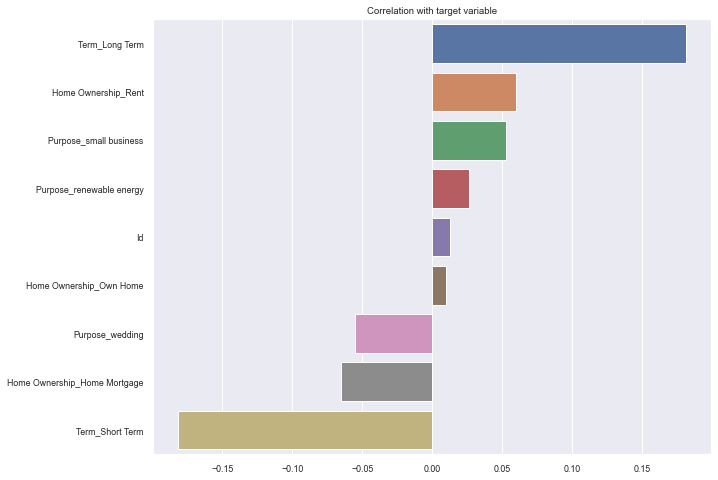

In [27]:
corr_with_target = train_df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [28]:
for colname in CAT_FEATURE_NAMES :
    train_df[colname] = train_df[colname].astype(str)  

### 2.2. Числовые признаки

Months since last delinquent - отличается train и test. Удаляем из таблиц

In [29]:
# train_df["Months since last delinquent"] = train_df["Months since last delinquent"].fillna(0)

Bankruptcies. Корреляции нет. Самое частое значение = 0 - отличается train и test. Удаляем из таблиц

In [30]:
#Удалим признаки у которых разное распределение на тесте и на трейне
BASE_FEATURE_NAMES.remove('Months since last delinquent')
NUM_FEATURE_NAMES.remove('Months since last delinquent')
train_df.drop(['Months since last delinquent'], axis='columns', inplace=True)
test_df.drop(['Months since last delinquent'], axis='columns', inplace=True)

BASE_FEATURE_NAMES.remove('Bankruptcies')
NUM_FEATURE_NAMES.remove('Bankruptcies')
train_df.drop(['Bankruptcies'], axis='columns', inplace=True)
test_df.drop(['Bankruptcies'], axis='columns', inplace=True)

Annual Income заполним медианным значением

In [31]:
train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median())

<AxesSubplot:>

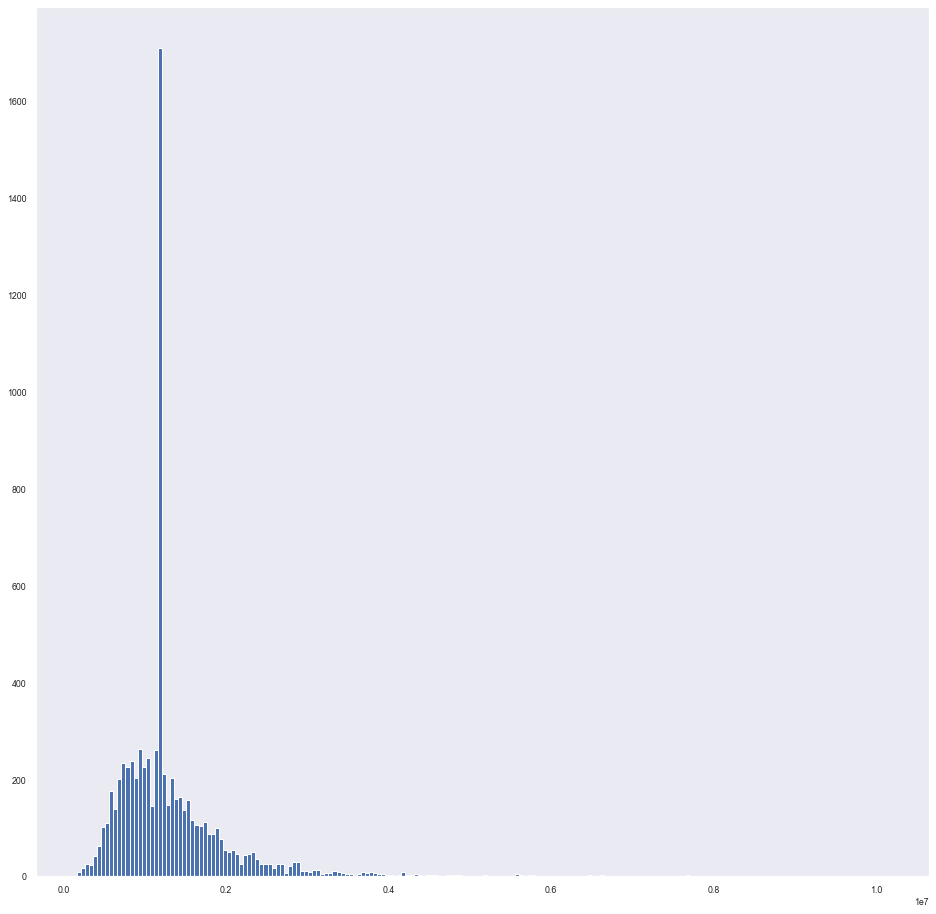

In [32]:
train_df.loc[train_df["Annual Income"] > 0, "Annual Income" ].hist(figsize=(16,16), bins=200, grid=False)

Current Loan Amount  явно имеет выбросы. Все что > 1000000 равно 99999999. Заменим эти значения на среднее без учета выбросов

<AxesSubplot:>

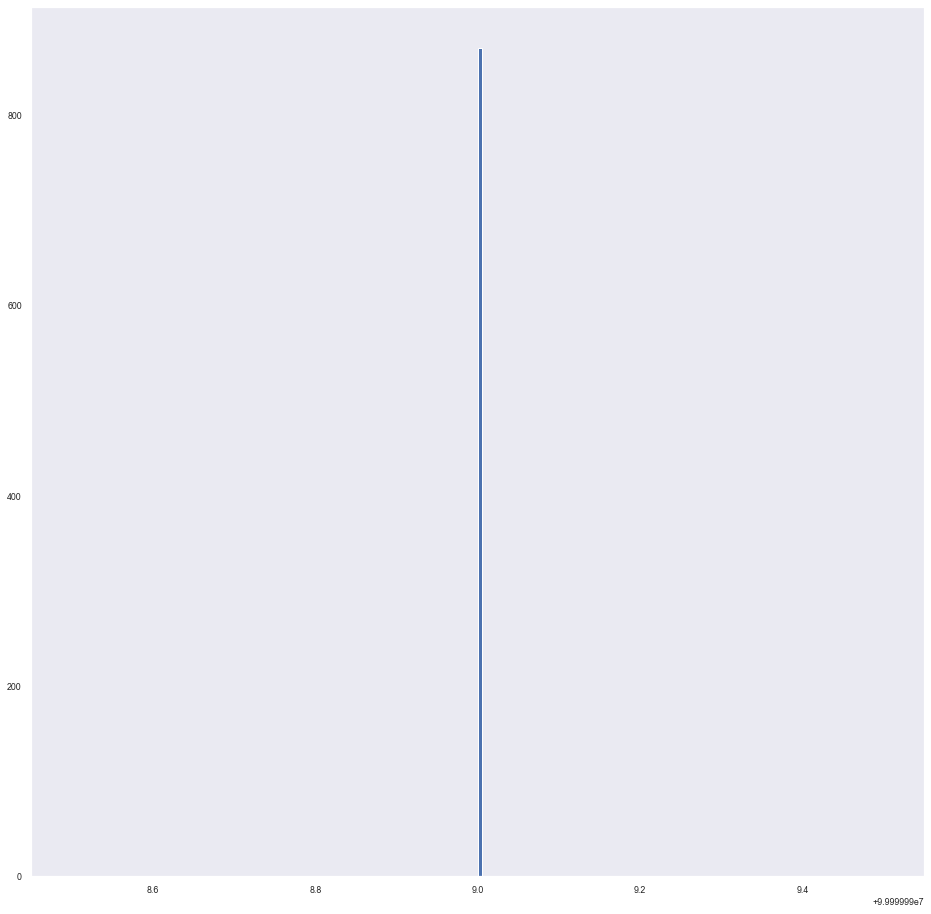

In [33]:
train_df.loc[train_df["Current Loan Amount"] > 1000000, "Current Loan Amount" ].hist(figsize=(16,16), bins=200, grid=False)

<AxesSubplot:>

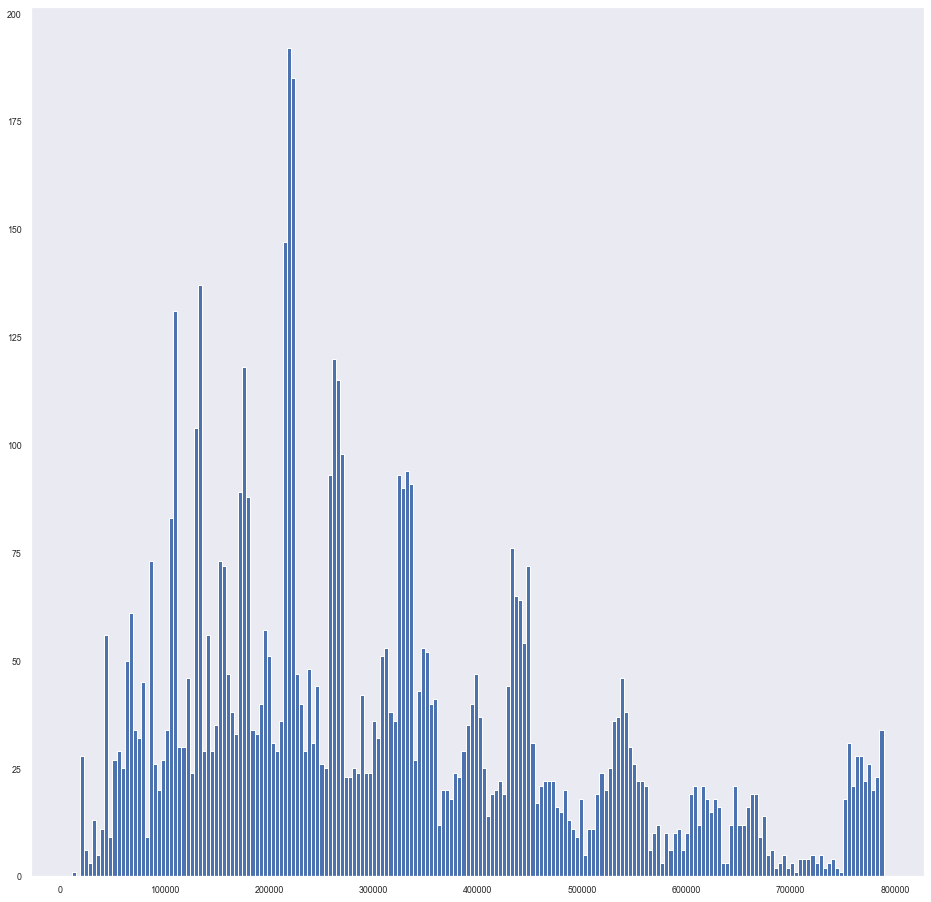

In [34]:
train_df.loc[train_df["Current Loan Amount"] <= 1000000, "Current Loan Amount"].hist(figsize=(16,16), bins=200, grid=False)

In [35]:
train_df.loc[train_df["Current Loan Amount"] > 1000000, "Current Loan Amount"] = train_df.loc[train_df["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()

Credit Score  (Сильная коррелляция с целевой переменной)

<AxesSubplot:>

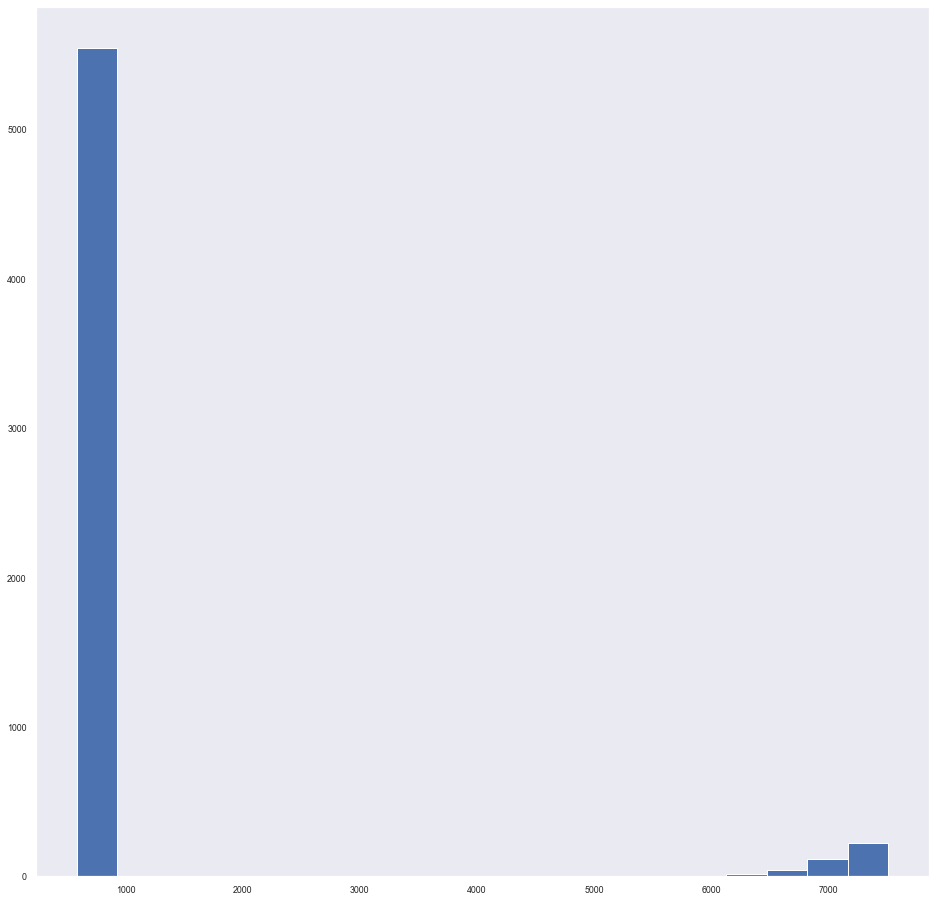

In [36]:
train_df['Credit Score'].hist(figsize=(16,16), bins=20, grid=False)

Все что больше 1000 будем считать выбросом

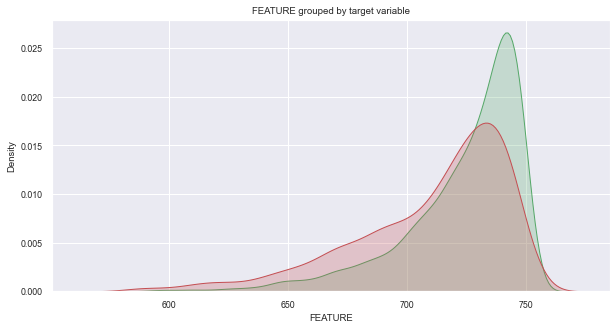

In [37]:
FEATURE_with_target = train_df[['Credit Score', TARGET_NAME]]
FEATURE = FEATURE_with_target['Credit Score']
FEATURE_target_0 = FEATURE[(FEATURE_with_target[TARGET_NAME] == 0) & (FEATURE_with_target['Credit Score'] <= 1000)]
FEATURE_target_1 = FEATURE[(FEATURE_with_target[TARGET_NAME] == 1) & (FEATURE_with_target['Credit Score'] <= 1000)]

plt.figure(figsize=(10, 5))

sns.kdeplot(FEATURE_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(FEATURE_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('FEATURE')
plt.title('FEATURE grouped by target variable')
plt.show()

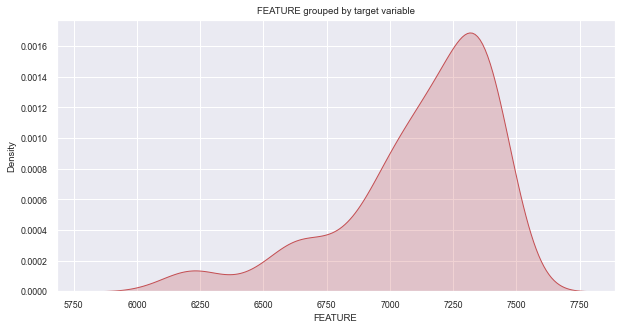

In [38]:
FEATURE_with_target = train_df[['Credit Score', TARGET_NAME]]
FEATURE = FEATURE_with_target['Credit Score']
FEATURE_target_0 = FEATURE[(FEATURE_with_target[TARGET_NAME] == 0) & (FEATURE_with_target['Credit Score'] > 1000)]
FEATURE_target_1 = FEATURE[(FEATURE_with_target[TARGET_NAME] == 1) & (FEATURE_with_target['Credit Score'] > 1000)]

plt.figure(figsize=(10, 5))

sns.kdeplot(FEATURE_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(FEATURE_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('FEATURE')
plt.title('FEATURE grouped by target variable')
plt.show()

Чем выше рейтинг (до 760) , тем меньше вероятность просрочки. То что > 1000 все в просрочке. Поэтому таким строкам присвоим 0

In [39]:
train_df.loc[train_df["Credit Score"] > 1000, "Credit Score"] = 0

Пропуски: 
    В строках где целевая переменная = 0 (нет просрочки) поставим значение 750
    В строках где целевая переменная = 1 (просрочка) поставим 0

In [40]:
#train_df.loc[(train_df['Term_Long Term'] == 1) & (train_df["Credit Score"].isnull()), "Credit Score"] = 0

In [41]:
#train_df.loc[(train_df['Term_Short Term'] == 1) & (train_df["Credit Score"].isnull()), "Credit Score"] = 750

In [42]:
#train_df["Credit Score"] = train_df["Credit Score"].fillna(train_df["Credit Score"].median()) #
train_df = train_df.drop(train_df[train_df["Credit Score"].isnull()].index)

Посмотрим на остальные выбросы

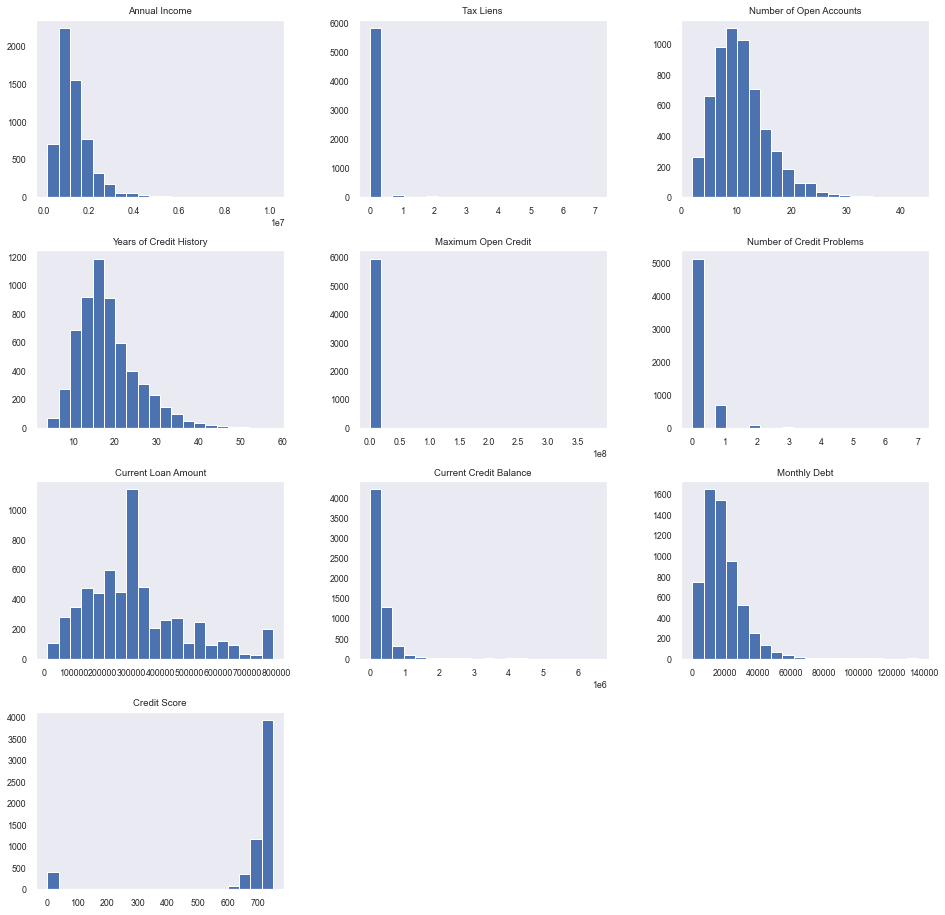

In [43]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

Current Credit Balance. нет корреляции с целевой переменной. Смотрим возможные выбросы. Нет явных выбросов

Maximum Open Credit. Нет корреляции с целевым признаком. Выбросы все что > 10000000

<AxesSubplot:>

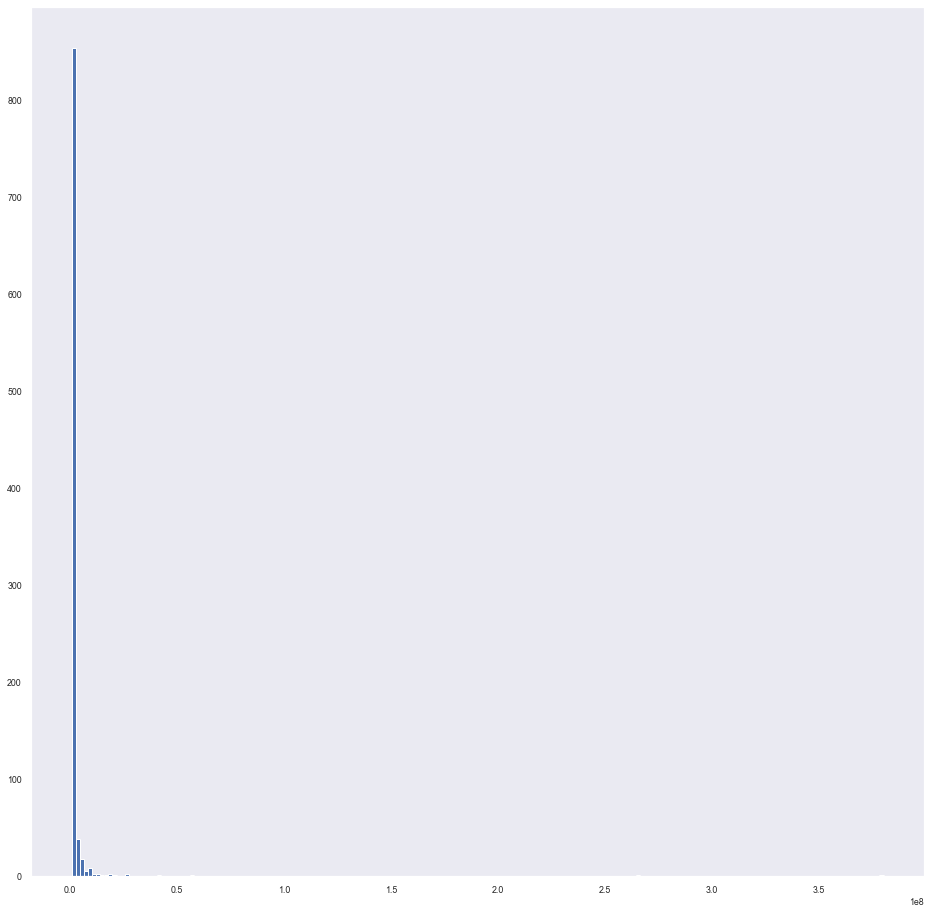

In [44]:
train_df.loc[train_df["Maximum Open Credit"] > 1000000, "Maximum Open Credit"].hist(figsize=(16,16), bins=200, grid=False)

In [45]:
train_df.loc[train_df["Maximum Open Credit"] > 10000000, "Maximum Open Credit"] = train_df.loc[train_df["Maximum Open Credit"] <= 10000000, "Maximum Open Credit"].mean()

Monthly Debt. Считаем что нет выбросов

Number of Credit Problems. Максимальное значение 7 и при этом нет корреляции с целевой переменной. Считаем что нет выбросов

Возможно если убрать значение 7, то появится корреляция

Number of Open Accounts. Слабая корреляция. Странно что бывают 20 - 30 открытых счетов, но таких много. Оставим как есть.

<AxesSubplot:>

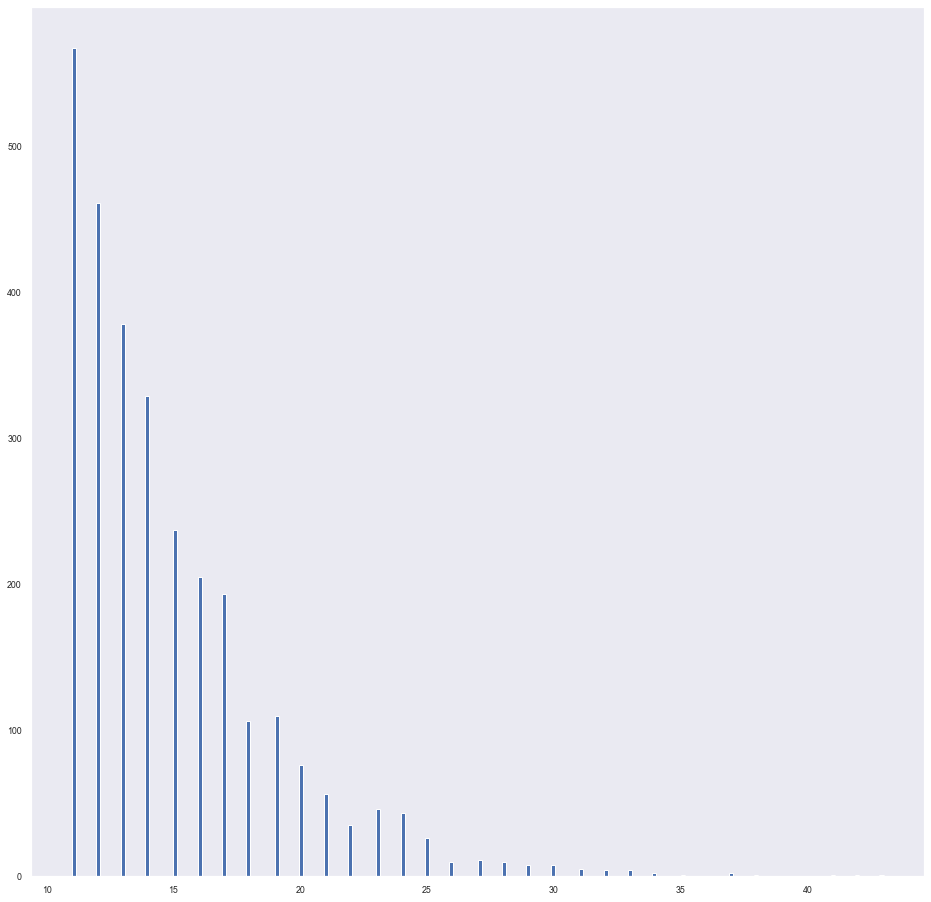

In [46]:
train_df.loc[train_df["Number of Open Accounts"] > 10, "Number of Open Accounts"].hist(figsize=(16,16), bins=200, grid=False)

Tax Liens. Максимальное значение 7. Корреляции нет. Считаем что нет выбросов

Years of Credit History. Корреляции нет. Значения в разумных пределах. Считаем что нет выбросов

## 3. Обучение модели

In [47]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [48]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [49]:
SELECTED_FEATURE_NAMES = NEW_FEATURE_NAMES + NUM_FEATURE_NAMES

In [50]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
X_train.shape, X_test.shape

((4160, 19), (1783, 19))

### 3.1. Смотрим базовые модели. Нас интересует f-мера для класса 1 и macro

### Логистическая регрессия

In [52]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      3051
           1       0.94      0.26      0.40      1109

    accuracy                           0.80      4160
   macro avg       0.86      0.62      0.64      4160
weighted avg       0.83      0.80      0.75      4160

TEST

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1308
           1       0.96      0.27      0.43       475

    accuracy                           0.80      1783
   macro avg       0.87      0.63      0.65      1783
weighted avg       0.83      0.80      0.76      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1302    6
1                345  130


### KNN (к ближайших соседей)

In [53]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      3051
           1       0.67      0.35      0.46      1109

    accuracy                           0.78      4160
   macro avg       0.74      0.64      0.66      4160
weighted avg       0.77      0.78      0.76      4160

TEST

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1308
           1       0.38      0.22      0.28       475

    accuracy                           0.70      1783
   macro avg       0.57      0.54      0.54      1783
weighted avg       0.65      0.70      0.67      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1141  167
1                372  103


### Дерево решений. 1 класса в 2,55 раз меньше чем 0 класса. Вводим коэффициенты через class_weight

In [54]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.55},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      3051
           1       0.49      0.54      0.51      1109

    accuracy                           0.73      4160
   macro avg       0.66      0.67      0.66      4160
weighted avg       0.74      0.73      0.73      4160

TEST

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1308
           1       0.49      0.54      0.51       475

    accuracy                           0.73      1783
   macro avg       0.66      0.67      0.66      1783
weighted avg       0.74      0.73      0.73      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1046  262
1                220  255


### XGBoost

In [55]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3051
           1       1.00      0.96      0.98      1109

    accuracy                           0.99      4160
   macro avg       0.99      0.98      0.99      4160
weighted avg       0.99      0.99      0.99      4160

TEST

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1308
           1       0.64      0.37      0.47       475

    accuracy                           0.78      1783
   macro avg       0.72      0.65      0.66      1783
weighted avg       0.76      0.78      0.75      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1212   96
1                301  174
Wall time: 1.13 s


### LightGBM

In [56]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:2.55},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3051
           1       0.93      0.98      0.95      1109

    accuracy                           0.97      4160
   macro avg       0.96      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1308
           1       0.52      0.49      0.51       475

    accuracy                           0.75      1783
   macro avg       0.67      0.66      0.67      1783
weighted avg       0.74      0.75      0.74      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1095  213
1                241  234
Wall time: 451 ms


### CatBoost

In [57]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3051
           1       1.00      0.59      0.74      1109

    accuracy                           0.89      4160
   macro avg       0.93      0.79      0.84      4160
weighted avg       0.90      0.89      0.88      4160

TEST

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      1308
           1       0.89      0.32      0.48       475

    accuracy                           0.81      1783
   macro avg       0.85      0.65      0.68      1783
weighted avg       0.82      0.81      0.77      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1289   19
1                321  154
Wall time: 5.16 s


### 3.2. Настраиваем CatBoost

CatBoost использует категории самостоятельно. То есть убираем get_dummies и оставляем обычные категориальные признаки. 
У CatBoost встроена балансировка.

In [58]:
X = train_df[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

Сколько уникальных значений в каждой категории (Это нужно чтобы установить параметр one_hot_max_size):

In [59]:
X_train[CAT_FEATURE_NAMES]['Purpose'].nunique()

2

In [60]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.751127141568981

In [61]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     one_hot_max_size=3,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3051
           1       0.82      0.93      0.87      1109

    accuracy                           0.93      4160
   macro avg       0.90      0.93      0.91      4160
weighted avg       0.93      0.93      0.93      4160

TEST

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1308
           1       0.50      0.55      0.52       475

    accuracy                           0.73      1783
   macro avg       0.67      0.67      0.67      1783
weighted avg       0.74      0.73      0.74      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1049  259
1                215  260


Параметр one_hot_max_size и устранение дисбаланса особо не помогли. Включаем визуализацию обучения

In [62]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                      early_stopping_rounds=20,
                                      use_best_model=True,
                                      custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.6798917944093779,
  'Logloss': 0.4965061994579565,
  'F1': 0.725506456142828,
  'Precision:use_weights=false': 0.5597624350408315,
  'Precision:use_weights=true': 0.7776819640990607,
  'Recall:use_weights=true': 0.6798917944093779},
 'validation': {'Recall:use_weights=false': 0.6231578947368421,
  'Logloss': 0.5268782195516118,
  'F1': 0.6831316962667973,
  'Precision:use_weights=false': 0.55863539445629,
  'Precision:use_weights=true': 0.7768904503030991,
  'Recall:use_weights=true': 0.6231578947368421}}

In [64]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      3051
           1       0.54      0.65      0.59      1109

    accuracy                           0.76      4160
   macro avg       0.70      0.72      0.71      4160
weighted avg       0.78      0.76      0.76      4160

TEST

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1308
           1       0.53      0.62      0.57       475

    accuracy                           0.75      1783
   macro avg       0.69      0.71      0.70      1783
weighted avg       0.77      0.75      0.76      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1045  263
1                179  296


Попробуем подобрать гиперпараметры.

In [65]:
# frozen_params = {
#      'class_weights':[1, disbalance], 
#      'silent':True,
#      'random_state':21,
#      'cat_features':CAT_FEATURE_NAMES,
#      'eval_metric':'F1',
#      'early_stopping_rounds':20
# }
# model_catb = catb.CatBoostClassifier(**frozen_params)

In [66]:
# params = {'iterations':[50, 200, 500, 700, 1500],
#           'max_depth':[3, 5, 7]}

In [67]:
# cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [68]:
# grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

In [69]:
# grid_search

In [70]:
# %%time

# final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=3)
# final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

# evaluate_preds(final_model, X_train, X_test, y_train, y_test)

## 4. РЕШЕНИЕ

In [71]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = train_df.columns.drop(CAT_FEATURE_NAMES + [TARGET_NAME]).tolist()


In [72]:
class DataPreprocessing:

    def __init__(self):
        self.CAT_FEATURE_NAMES = None
        
        
    def transform(self, df, is_test):
      
        #Категориальные признаки:

        df.loc[df['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

        df.drop(['Years in current job'], axis='columns', inplace=True)

        df.loc[df['Purpose'] == 'buy a car', "Purpose"] = 'vacation'
        df.loc[df['Purpose'] == 'buy house', "Purpose"] = 'debt consolidation'
        df.loc[df['Purpose'] == 'vacation', "Purpose"] = 'take a trip'

        df.loc[df['Purpose'] == 'medical bills', "Purpose"] = 'wedding'
        df.loc[df['Purpose'] == 'major purchase', "Purpose"] = 'wedding'
        df.loc[df['Purpose'] == 'moving', "Purpose"] = 'wedding'

        df.loc[df['Purpose'] == 'take a trip', "Purpose"] = 'wedding'
        df.loc[df['Purpose'] == 'home improvements', "Purpose"] = 'wedding'
        df.loc[df['Purpose'] == 'debt consolidation', "Purpose"] = 'wedding'

        df.loc[df['Purpose'] == 'business loan', "Purpose"] = 'small business'
        df.loc[df['Purpose'] == 'educational expenses', "Purpose"] = 'wedding'
        df.loc[df['Purpose'] == 'other', "Purpose"] = 'wedding'

        for colname in self.CAT_FEATURE_NAMES :
            df[colname] = df[colname].astype(str)


        #Числовые признаки:
        #Удалим признаки у которых разное распределение на тесте и на трейне

        df.drop(['Months since last delinquent'], axis='columns', inplace=True)
        df.drop(['Bankruptcies'], axis='columns', inplace=True)

        df["Annual Income"] = df["Annual Income"].fillna(df["Annual Income"].median())
        df.loc[df["Current Loan Amount"] > 1000000, "Current Loan Amount"] = df.loc[df["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()
        df.loc[df["Credit Score"] > 1000, "Credit Score"] = 0
        if not is_test:
            df = df.drop(df[df["Credit Score"].isnull()].index)
        df.loc[df["Maximum Open Credit"] > 10000000, "Maximum Open Credit"] = df.loc[df["Maximum Open Credit"] <= 10000000, "Maximum Open Credit"].mean()
        
        return df


In [73]:
BASE_FEATURE_NAMES.remove('Years in current job')
CAT_FEATURE_NAMES.remove('Years in current job')
BASE_FEATURE_NAMES.remove('Months since last delinquent')
NUM_FEATURE_NAMES.remove('Months since last delinquent')
BASE_FEATURE_NAMES.remove('Bankruptcies')
NUM_FEATURE_NAMES.remove('Bankruptcies')

In [74]:
preprocessor = DataPreprocessing()
preprocessor.CAT_FEATURE_NAMES = CAT_FEATURE_NAMES
train_df = preprocessor.transform(train_df, False)
test_df = preprocessor.transform(test_df, True)

In [75]:
X = train_df[BASE_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)


disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                      early_stopping_rounds=20,
                                      use_best_model=True,
                                      custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3051
           1       0.53      0.64      0.58      1109

    accuracy                           0.75      4160
   macro avg       0.70      0.72      0.70      4160
weighted avg       0.77      0.75      0.76      4160

TEST

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1308
           1       0.52      0.63      0.57       475

    accuracy                           0.75      1783
   macro avg       0.69      0.71      0.70      1783
weighted avg       0.77      0.75      0.75      1783

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1032  276
1                175  300


In [76]:
sample_submission_PATH = 'sample_submission.csv'
submit = pd.read_csv(sample_submission_PATH)
predictions = model_catb.predict(test_df)

submit['Credit Default'] = predictions
submit.to_csv('Credit_default_prediction2.csv', index=False)
submit.head()


,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
